In [1]:
# imports, constants, definitions

import pickle
from matplotlib import pyplot as plt, ticker
from datetime import datetime
from scipy.optimize import curve_fit
import pandas as pd
        
def gas_quantiles(txs, numquantiles):
    quantiles = [None] * (numquantiles - 1)
    cumulative_gas = 0
    total_gas = sum(tx.gas_used for tx in txs)
    for tx in sorted(txs, key=lambda k: k.gas_price):
        cumulative_gas += tx.gas_used
        for i, q in enumerate(quantiles):
            if q is None and cumulative_gas >= total_gas * (i + 1) / numquantiles:
                quantiles[i] = tx.gas_price
    
    return quantiles

class Tx:   
    def __init__(self, tx_type, gas_used, gas_price):
        self.tx_type = tx_type
        self.gas_used = gas_used
        self.gas_price = gas_price

class Block:
    def __init__(self, blocknum):
        self.blocknum = blocknum
        batch_request = [
            request("eth_getBlockByNumber", [blocknum, True]),
            request("eth_getBlockReceipts", [blocknum])
        ]
        
        response = requests.post(ERIGON_URL, json=batch_request).json()
        self.ts = int(response[0]['result']['timestamp'], base=16)
        self.dt = datetime.utcfromtimestamp(self.ts)
        tx_json = response[0]['result']['transactions']
        receipts_json = response[1]['result']
        
        if len(tx_json) > 0:
            tmp = sorted(
                zip(tx_json, receipts_json),
                key=lambda k: int(k[1]['effectiveGasPrice'], base=16)
            )
            tx_json, receipts_json = zip(*tmp)
            
        self.txs = []
        for t, r in zip(tx_json, receipts_json):
            gas_used = int(r['gasUsed'], base=16)
            tx_type = int(r['type'], base=16)
            if tx_type == 2 and (t['maxFeePerGas'] == t['maxPriorityFeePerGas']):
                tx_type = 3
            gas_price = int(r['effectiveGasPrice'], base=16)
            self.txs += [Tx(tx_type, gas_used, gas_price)]
            
class WindowSeries:
    def __init__(self, start_ts, period, numquantiles):
        self.start_ts = start_ts
        self.period = period
        self.numquantiles = numquantiles
        self.numperiods = 0
        self.block_cache = []
        self.quantile_series_legacy = []
        self.quantile_series_type2 = []
    
    def add_block(self, block):
        period_start = self.start_ts + self.period * self.numperiods
        
        if block.ts >= period_start + self.period:
            self.process_cache()
        else:
            self.block_cache += [block]
    
    def process_cache(self):
        total_legacy_gas = 0
        total_type2_gas = 0
        legacy_txs = []
        type2_txs = []
        for block in self.block_cache:
            for tx in block.txs:
                if tx.tx_type > 1:
                    total_type2_gas += tx.gas_used
                    type2_txs += [tx]
                else:
                    total_legacy_gas += tx.gas_used
                    legacy_txs += [tx]
        
        self.quantile_series_legacy += [gas_quantiles(legacy_txs, self.numquantiles)]
        self.quantile_series_type2 += [gas_quantiles(type2_txs, self.numquantiles)]
        self.block_cache = []
        self.numperiods += 1

restored_data = False
try:
    with open('gas-market-analysis.pkl', 'rb') as f:
        window_series, legacy_gas_per_day, eip1559_gas_per_day, hybrid_gas_per_day = pickle.load(f)
    restored_data = True
except:
    print('cannot open pickle file')

R² = 0.45


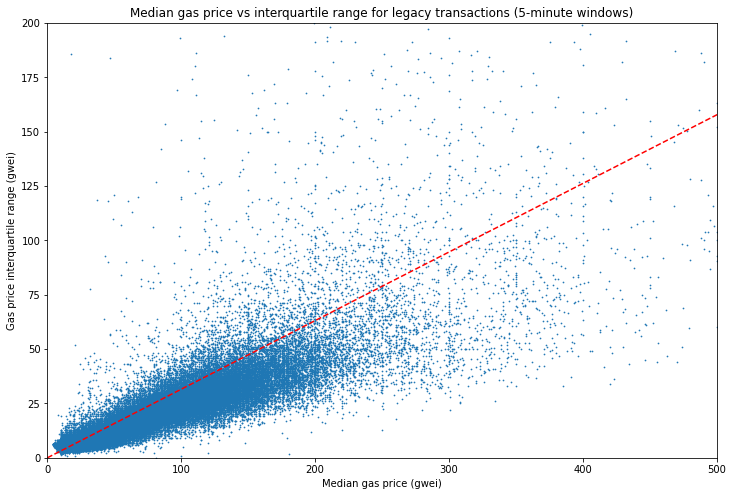

In [2]:
# investigate median gas price and iqr

ws = window_series[1]
x = [
    datetime.utcfromtimestamp(ws.start_ts + i * ws.period) for i in range(ws.numperiods)
]
series_legacy = [list(i) for i in zip(*ws.quantile_series_legacy)]
series_type2 = [list(i) for i in zip(*ws.quantile_series_type2)]

df_legacy = pd.DataFrame({
    '1st quartile':series_legacy[0],
    'median':      series_legacy[1],
    '3rd quartile':series_legacy[2]
}, index=x)

df_type2 = pd.DataFrame({
    '1st quartile':series_type2[0],
    'median':    series_type2[1],
    '3rd quartile':series_type2[2]
}, index=x)

fig, ax = plt.subplots(figsize=(12, 8))
x = df_legacy['median'] / 1e9
y = (df_legacy['3rd quartile'] - df_legacy['1st quartile']) / 1e9
ax.scatter(x, y, s=0.5)
ax.set_xlim(xmin=0, xmax=500)
ax.set_ylim(ymin=0, ymax=200)
ax.set_title('Median gas price vs interquartile range for legacy transactions (5-minute windows)')
ax.set_xlabel('Median gas price (gwei)')
ax.set_ylabel('Gas price interquartile range (gwei)')

# get line of best fit

def func(x, a):
    return a * x

popt, pcov = curve_fit(func, x, y)
ax.plot([0, max(x)], func([0,max(x)], popt),"r--")

# calculate R^2 value

ss_res = sum([r**2 for r in y - func(x, *popt)])
ybar = sum(y) / len(y)
ss_tot = sum([(yi - ybar)**2 for yi in y])
r_squared = 1 - (ss_res / ss_tot)
print(f"R\u00b2 = {r_squared:.2f}")

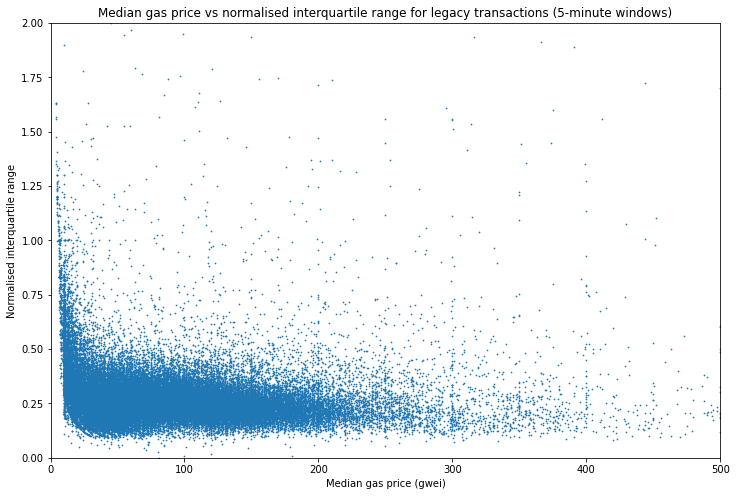

In [3]:
# plot normalised iqr against median

fig, ax = plt.subplots(figsize=(12, 8))
x = df_legacy['median'] / 1e9
y = (df_legacy['3rd quartile'] - df_legacy['1st quartile']) / df_legacy['median']
ax.scatter(x, y, s=0.5)
ax.set_xlim(xmin=0, xmax=500)
ax.set_ylim(ymin=0, ymax=2)
ax.set_title('Median gas price vs normalised interquartile range for legacy transactions (5-minute windows)')
ax.set_xlabel('Median gas price (gwei)')
ax.set_ylabel('Normalised interquartile range');